In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error
import keras
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, Flatten, Input, dot
from keras import Model
from IPython.display import SVG
%matplotlib inline

### Read dataset

In [2]:
# Define attributes of u.item
FieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
      'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
      'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']

# Read the data into dataframes
DataDf = pd.read_csv("ml-100k/u.data", sep='\t', names=["user_id", "item_id", "rating", "timestamp"])
Itemdata = pd.read_csv("ml-100k/u.item", sep='|', encoding = "ISO-8859-1", names=FieldsMovies)

# Setups
FindID = Itemdata.movieTitle.to_dict()  # key: movieID-1, value:movie title
NumItems = len(DataDf.item_id.unique())
NumUsers = len(DataDf.user_id.unique())

In [3]:
DataDf = DataDf.drop('timestamp', axis=1)
DataDf.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [4]:
DataDf.describe()

,user_id,item_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


Let's see how many unique users and items (movies) in the dataset.

In [5]:
print("Number of Users: {}\nNumber of Movies: {}".format(NumUsers, NumItems))

Number of Users: 943
Number of Movies: 1682


### Train Test Split

In [6]:
train, test = train_test_split(DataDf, test_size=0.2)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Cosine Similarity

In [7]:
def buildItemUserMatrix(dataDf):
    '''
    Input
    - datadf: A pandas dataframe of movielens dataset

    Ouput
    - matrix: A 2d numpy array of Item-User Matrix (numItems x numUsers)
    '''
    dataMatrix = np.zeros((NumItems, NumUsers), dtype=np.int8)

    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating) in dataDf.itertuples():
        dataMatrix[itemID-1, userID-1] = rating
    return dataMatrix

def getSimilarMovies(similarity, movieID, k=5):
    '''
    Recommend k-number of similar movie by cosine similarity metric
    '''
    movieVec = similarity[movieID-1]
    movieVec = np.delete(movieVec, movieID-1)
    sortedIdx = np.argsort(movieVec)[::-1]
    print("Did you like '{}'?\n".format(FindID[movieID-1]))
    print("What we recommend for you")
    for i in range(k):
        movietitle = FindID[sortedIdx[i+1]+1]
        print("{}: {}".format(i+1, movietitle))

def whichMovie(movieID):
    return FindID[movieID-1]

def predictRatings(trainDf, similarity):
    '''
    Predict empty ratings by using item-cosine-similarity
    '''
    dataMatrix = buildItemUserMatrix(trainDf)
    predictionMatrix = np.zeros((NumItems, NumUsers))
    
    # loop over non-rated items
    for u in range(NumUsers):
        userVector = dataMatrix[:,u]
        nonzeros = userVector.nonzero()
        itemRatings = userVector[nonzeros]
        zeros = np.argwhere(userVector == 0).flatten()

        for i in zeros:
            # Get the similarity score for each of the items that provided rating by this user
            itemSims = similarity[i,:][nonzeros]

            if itemSims.sum() == 0:
                continue
            else:
                #Predict score based on item-item similarity
                predictionMatrix[i,u] = (itemRatings * itemSims).sum() / itemSims.sum()
    
    return predictionMatrix

def recommendMovies(userID, **options):
    '''
    Recommend movies for the user with userID
    '''
    # Read options args
    model = options.pop('model', None)
    trainDf = options.pop('train_data', None)
    similarity = options.pop('similarity', None)
    predictionMatrix = options.pop('prediction_matrix', None)
    k = options.pop('k', 10)
    
    if options:
        raise TypeError("Invalid parameters passed: %s" % str(options))

    
    
    recMovies = []
    
    # if trained model was passed in
    if model:
        pairs = [ np.array([userID] * NumUsers),
                 np.array([itemID for itemID in range(1, NumItems+1)]) ]
        pred = model.predict(pairs)
        argmaxIdx = np.argsort(pred, axis=0)[::-1].squeeze()
        argmaxIdx = argmaxIdx[:k]

        # Get the k-highest scored movies in the predictions list
        for i in argmaxIdx:
            recMovies.append(FindID[i])

        return recMovies
    
    # if similarity matrix was passed in, use cosine similarity
    elif similarity is not None:

        # if trainDf is None, raise error
        if trainDf is None:
            raise BaseException("Invalid data types passed")
        
        # if prediction matrix is None, calculate it
        if predictionMatrix is None:
            predictionMatrix = predictRatings(trainDf, similarity)
         
        userVector = predictionMatrix[:, userID-1]
        argmaxIdx = np.argsort(userVector, axis=0)[::-1].squeeze()
        
        if len(argmaxIdx) >= k:
            argmaxIdx = argmaxIdx[:k]
        
        # Get the k-highest scored movies in the predictions list
        for i in argmaxIdx:
            recMovies.append(FindID[i])

        return recMovies

def usersBestMovies(dataDf, userID):
    '''
    Find the best rated movies for the user
    '''
    # if the userID is not found in the data, print error message
    if len(dataDf.loc[dataDf['user_id'] == userID]) == 0:
        print("'User_ID {}' is not in our database!".format(userID))
        return
    
    # Return all the movies which were rated the highest score by the user
    maxrating = dataDf.loc[dataDf['user_id']==userID].rating.max()
    bestMovieIDs = dataDf.loc[(dataDf['user_id']==userID) &
                            (dataDf['rating']==maxrating)].item_id
    
    # Store the best movies
    bestMovies = []
    for movieID in bestMovieIDs:
        bestMovies.append(FindID[movieID-1])
        
    return bestMovies

In [8]:
dataMatrix = buildItemUserMatrix(DataDf)
similarity = cosine_similarity(dataMatrix)
trainMatrix = buildItemUserMatrix(train)
testMatrix = buildItemUserMatrix(test)
pred_Matrix = predictRatings(train, similarity)

In [9]:
# add predicted scores in the test dataframe
for ind, userID, itemID, rating in test.itertuples():
    test.loc[ind, 'pred_cosSim'] = pred_Matrix[itemID-1, userID-1]

rmse_similarity = np.sqrt(mean_squared_error(test.rating, test.pred_cosSim))
rmse_similarity_round = np.sqrt(mean_squared_error(test.rating, np.round(test.pred_cosSim)))
print("Root Mean Square Error {}".format(rmse_similarity))
print("Root Mean Square Error (rounded) {}".format(rmse_similarity_round))

Root Mean Square Error 1.014304047219637
Root Mean Square Error (rounded) 1.0517128885774862


### Matrix Factorization Using Keras

In [52]:
# hyperparameters
n_latent_factors = 3

# Define movies (items) matrix
# shape: (batch_size, embedding_size)
movie_input = Input(shape=[1], name='Item')
movie_embedding = Embedding(input_dim=NumItems+1, output_dim=n_latent_factors,
                                         name='Movie-Embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

# Define users matrix
user_input = Input(shape=[1], name='User')
user_embedding = Embedding(input_dim=NumUsers+1, output_dim=n_latent_factors,
                                        name='User-Embedding')(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

# Build model
prod = dot([movie_vec, user_vec], axes=1, name='DotProduct')

model = Model([user_input, movie_input], prod)
model.compile(optimizer='adam', loss='mse')

In [53]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
User (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
Movie-Embedding (Embedding)     (None, 1, 3)         5049        Item[0][0]                       
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 3)         2832        User[0][0]                       
__________________________________________________________________________________________________
FlattenMov

In [54]:
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

history = model.fit([train.user_id, train.item_id], train.rating,
                    batch_size=64, epochs=300, validation_split=0.1,
                    shuffle=True, verbose=2, callbacks=[checkpointer])

Train on 72000 samples, validate on 8000 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 11.90445, saving model to weights.hdf5
 - 3s - loss: 13.4098 - val_loss: 11.9045
Epoch 2/300

Epoch 00002: val_loss improved from 11.90445 to 5.36067, saving model to weights.hdf5
 - 2s - loss: 8.4757 - val_loss: 5.3607
Epoch 3/300

Epoch 00003: val_loss improved from 5.36067 to 2.58545, saving model to weights.hdf5
 - 2s - loss: 3.6576 - val_loss: 2.5855
Epoch 4/300

Epoch 00004: val_loss improved from 2.58545 to 1.76567, saving model to weights.hdf5
 - 3s - loss: 2.0643 - val_loss: 1.7657
Epoch 5/300

Epoch 00005: val_loss improved from 1.76567 to 1.40348, saving model to weights.hdf5
 - 2s - loss: 1.5061 - val_loss: 1.4035
Epoch 6/300

Epoch 00006: val_loss improved from 1.40348 to 1.21290, saving model to weights.hdf5
 - 3s - loss: 1.2380 - val_loss: 1.2129
Epoch 7/300

Epoch 00007: val_loss improved from 1.21290 to 1.10380, saving model to weights.hdf5
 - 2s - loss: 1.0932 - va


Epoch 00063: val_loss improved from 0.87524 to 0.87442, saving model to weights.hdf5
 - 2s - loss: 0.7496 - val_loss: 0.8744
Epoch 64/300

Epoch 00064: val_loss did not improve
 - 2s - loss: 0.7471 - val_loss: 0.8750
Epoch 65/300

Epoch 00065: val_loss did not improve
 - 2s - loss: 0.7447 - val_loss: 0.8755
Epoch 66/300

Epoch 00066: val_loss did not improve
 - 2s - loss: 0.7424 - val_loss: 0.8754
Epoch 67/300

Epoch 00067: val_loss did not improve
 - 2s - loss: 0.7403 - val_loss: 0.8754
Epoch 68/300

Epoch 00068: val_loss did not improve
 - 2s - loss: 0.7382 - val_loss: 0.8756
Epoch 69/300

Epoch 00069: val_loss did not improve
 - 2s - loss: 0.7361 - val_loss: 0.8755
Epoch 70/300

Epoch 00070: val_loss did not improve
 - 2s - loss: 0.7345 - val_loss: 0.8759
Epoch 71/300

Epoch 00071: val_loss did not improve
 - 2s - loss: 0.7330 - val_loss: 0.8760
Epoch 72/300

Epoch 00072: val_loss did not improve
 - 3s - loss: 0.7311 - val_loss: 0.8766
Epoch 73/300

Epoch 00073: val_loss did not im


Epoch 00151: val_loss did not improve
 - 2s - loss: 0.6962 - val_loss: 0.8978
Epoch 152/300

Epoch 00152: val_loss did not improve
 - 2s - loss: 0.6961 - val_loss: 0.8977
Epoch 153/300

Epoch 00153: val_loss did not improve
 - 2s - loss: 0.6959 - val_loss: 0.8965
Epoch 154/300

Epoch 00154: val_loss did not improve
 - 2s - loss: 0.6959 - val_loss: 0.8972
Epoch 155/300

Epoch 00155: val_loss did not improve
 - 2s - loss: 0.6958 - val_loss: 0.8998
Epoch 156/300

Epoch 00156: val_loss did not improve
 - 2s - loss: 0.6956 - val_loss: 0.8998
Epoch 157/300

Epoch 00157: val_loss did not improve
 - 2s - loss: 0.6954 - val_loss: 0.9002
Epoch 158/300

Epoch 00158: val_loss did not improve
 - 2s - loss: 0.6954 - val_loss: 0.8997
Epoch 159/300

Epoch 00159: val_loss did not improve
 - 2s - loss: 0.6956 - val_loss: 0.9012
Epoch 160/300

Epoch 00160: val_loss did not improve
 - 2s - loss: 0.6951 - val_loss: 0.9013
Epoch 161/300

Epoch 00161: val_loss did not improve
 - 2s - loss: 0.6950 - val_loss

Epoch 240/300

Epoch 00240: val_loss did not improve
 - 2s - loss: 0.6903 - val_loss: 0.9219
Epoch 241/300

Epoch 00241: val_loss did not improve
 - 2s - loss: 0.6901 - val_loss: 0.9215
Epoch 242/300

Epoch 00242: val_loss did not improve
 - 2s - loss: 0.6902 - val_loss: 0.9224
Epoch 243/300

Epoch 00243: val_loss did not improve
 - 2s - loss: 0.6899 - val_loss: 0.9211
Epoch 244/300

Epoch 00244: val_loss did not improve
 - 2s - loss: 0.6900 - val_loss: 0.9221
Epoch 245/300

Epoch 00245: val_loss did not improve
 - 2s - loss: 0.6900 - val_loss: 0.9213
Epoch 246/300

Epoch 00246: val_loss did not improve
 - 2s - loss: 0.6899 - val_loss: 0.9219
Epoch 247/300

Epoch 00247: val_loss did not improve
 - 2s - loss: 0.6898 - val_loss: 0.9235
Epoch 248/300

Epoch 00248: val_loss did not improve
 - 2s - loss: 0.6898 - val_loss: 0.9233
Epoch 249/300

Epoch 00249: val_loss did not improve
 - 2s - loss: 0.6898 - val_loss: 0.9224
Epoch 250/300

Epoch 00250: val_loss did not improve
 - 2s - loss: 0.6

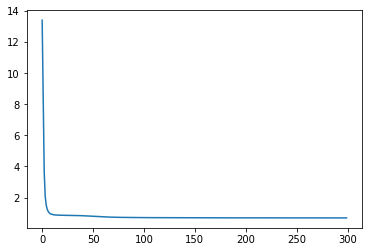

In [55]:
# Plot loss history
losshist = history.history['loss']
plt.plot(losshist)
plt.show()

In [56]:
# load the best model's parameters
model.load_weights("weights.hdf5")

# predict the ratings
y_pred = model.predict([test.user_id, test.item_id])
rmse_factorize = np.sqrt(mean_squared_error(test.rating, y_pred))
rmse_factorize_round = np.sqrt(mean_squared_error(test.rating, np.round(y_pred)))

# Print out the evaluation result
print("Root Mean Square Error {}".format(rmse_factorize))
print("Root Mean Square Error {}".format(rmse_factorize_round))

Root Mean Square Error 0.9362030419991877
Root Mean Square Error 0.9765756499114648


### Non-negative Matrix Factorization

In [116]:
from keras.constraints import non_neg
movie_input = Input(shape=[1],name='Item')
movie_embedding = Embedding(NumItems + 1, n_latent_factors, name='NonNegMovie-Embedding',
                                        embeddings_constraint=non_neg())(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

user_input = Input(shape=[1],name='User')
user_embedding = Embedding(NumUsers + 1, n_latent_factors,name='NonNegUser-Embedding',
                                        embeddings_constraint=non_neg())(user_input)
user_vec = Flatten(name='FlattenUsers')(user_embedding)

prod = dot([movie_vec, user_vec], axes=1, name='DotProduct')
model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

In [117]:
checkpointer = ModelCheckpoint(filepath="weights_nonneg.hdf5", verbose=1, save_best_only=True)

history_nonneg = model.fit([train.user_id, train.item_id], train.rating,
                    epochs=300, validation_split=0.1,
                    shuffle=True, verbose=2, callbacks=[checkpointer])

Train on 72000 samples, validate on 8000 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 7.39103, saving model to weights_nonneg.hdf5
 - 4s - loss: 11.2814 - val_loss: 7.3910
Epoch 2/300

Epoch 00002: val_loss improved from 7.39103 to 2.66735, saving model to weights_nonneg.hdf5
 - 3s - loss: 4.4185 - val_loss: 2.6674
Epoch 3/300

Epoch 00003: val_loss improved from 2.66735 to 1.62401, saving model to weights_nonneg.hdf5
 - 3s - loss: 1.9998 - val_loss: 1.6240
Epoch 4/300

Epoch 00004: val_loss improved from 1.62401 to 1.25216, saving model to weights_nonneg.hdf5
 - 3s - loss: 1.3666 - val_loss: 1.2522
Epoch 5/300

Epoch 00005: val_loss improved from 1.25216 to 1.09030, saving model to weights_nonneg.hdf5
 - 3s - loss: 1.1163 - val_loss: 1.0903
Epoch 6/300

Epoch 00006: val_loss improved from 1.09030 to 1.01256, saving model to weights_nonneg.hdf5
 - 3s - loss: 1.0035 - val_loss: 1.0126
Epoch 7/300

Epoch 00007: val_loss improved from 1.01256 to 0.97336, saving model to


Epoch 00069: val_loss did not improve
 - 3s - loss: 0.7676 - val_loss: 0.8818
Epoch 70/300

Epoch 00070: val_loss did not improve
 - 3s - loss: 0.7649 - val_loss: 0.8830
Epoch 71/300

Epoch 00071: val_loss did not improve
 - 3s - loss: 0.7625 - val_loss: 0.8849
Epoch 72/300

Epoch 00072: val_loss did not improve
 - 3s - loss: 0.7602 - val_loss: 0.8843
Epoch 73/300

Epoch 00073: val_loss did not improve
 - 3s - loss: 0.7576 - val_loss: 0.8835
Epoch 74/300

Epoch 00074: val_loss did not improve
 - 3s - loss: 0.7557 - val_loss: 0.8845
Epoch 75/300

Epoch 00075: val_loss did not improve
 - 3s - loss: 0.7537 - val_loss: 0.8859
Epoch 76/300

Epoch 00076: val_loss did not improve
 - 3s - loss: 0.7514 - val_loss: 0.8859
Epoch 77/300

Epoch 00077: val_loss did not improve
 - 3s - loss: 0.7502 - val_loss: 0.8838
Epoch 78/300

Epoch 00078: val_loss did not improve
 - 3s - loss: 0.7484 - val_loss: 0.8887
Epoch 79/300

Epoch 00079: val_loss did not improve
 - 3s - loss: 0.7468 - val_loss: 0.8868
E

Epoch 158/300

Epoch 00158: val_loss did not improve
 - 3s - loss: 0.7135 - val_loss: 0.8997
Epoch 159/300

Epoch 00159: val_loss did not improve
 - 3s - loss: 0.7137 - val_loss: 0.9017
Epoch 160/300

Epoch 00160: val_loss did not improve
 - 3s - loss: 0.7135 - val_loss: 0.9017
Epoch 161/300

Epoch 00161: val_loss did not improve
 - 3s - loss: 0.7135 - val_loss: 0.9013
Epoch 162/300

Epoch 00162: val_loss did not improve
 - 3s - loss: 0.7133 - val_loss: 0.9033
Epoch 163/300

Epoch 00163: val_loss did not improve
 - 3s - loss: 0.7131 - val_loss: 0.9023
Epoch 164/300

Epoch 00164: val_loss did not improve
 - 3s - loss: 0.7133 - val_loss: 0.9018
Epoch 165/300

Epoch 00165: val_loss did not improve
 - 3s - loss: 0.7128 - val_loss: 0.9015
Epoch 166/300

Epoch 00166: val_loss did not improve
 - 3s - loss: 0.7128 - val_loss: 0.9013
Epoch 167/300

Epoch 00167: val_loss did not improve
 - 3s - loss: 0.7128 - val_loss: 0.9008
Epoch 168/300

Epoch 00168: val_loss did not improve
 - 3s - loss: 0.7


Epoch 00246: val_loss did not improve
 - 3s - loss: 0.7083 - val_loss: 0.9043
Epoch 247/300

Epoch 00247: val_loss did not improve
 - 3s - loss: 0.7082 - val_loss: 0.9044
Epoch 248/300

Epoch 00248: val_loss did not improve
 - 3s - loss: 0.7080 - val_loss: 0.9047
Epoch 249/300

Epoch 00249: val_loss did not improve
 - 3s - loss: 0.7079 - val_loss: 0.9055
Epoch 250/300

Epoch 00250: val_loss did not improve
 - 3s - loss: 0.7081 - val_loss: 0.9055
Epoch 251/300

Epoch 00251: val_loss did not improve
 - 3s - loss: 0.7081 - val_loss: 0.9043
Epoch 252/300

Epoch 00252: val_loss did not improve
 - 3s - loss: 0.7080 - val_loss: 0.9058
Epoch 253/300

Epoch 00253: val_loss did not improve
 - 3s - loss: 0.7078 - val_loss: 0.9051
Epoch 254/300

Epoch 00254: val_loss did not improve
 - 3s - loss: 0.7079 - val_loss: 0.9061
Epoch 255/300

Epoch 00255: val_loss did not improve
 - 3s - loss: 0.7077 - val_loss: 0.9037
Epoch 256/300

Epoch 00256: val_loss did not improve
 - 3s - loss: 0.7080 - val_loss

In [13]:
# load the best model's parameters
model.load_weights("weights_nonneg.hdf5")

# predict the ratings
y_pred_nonneg = model.predict([test.user_id, test.item_id])
rmse_factorize = np.sqrt(mean_squared_error(test.rating, y_pred_nonneg))
rmse_factorize_rounded = np.sqrt(mean_squared_error(test.rating, np.round(y_pred_nonneg)))

# Print out the RMSE
print("Root Mean Square Error {}".format(rmse_factorize))
print("Root Mean Square Error (rounded) {}".format(rmse_factorize_rounded))

Root Mean Square Error 0.8895137984172732
Root Mean Square Error (rounded) 0.9341841360245848


### Fully Connected Neural Network

In [38]:
import math
from keras.callbacks import LearningRateScheduler

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [39]:
from keras.layers import concatenate, Dropout

# For each sample we input the integer identifiers
# of a single user and a single item
user_id_input = Input(shape=[1], name='user')
item_id_input = Input(shape=[1], name='item')

embedding_size = 50
user_embedding = Embedding(output_dim=embedding_size, input_dim=NumUsers + 1,
                           input_length=1, name='User-Embedding')(user_id_input)
item_embedding = Embedding(output_dim=embedding_size, input_dim=NumItems + 1,
                           input_length=1, name='Movie-Embedding')(item_id_input)


# reshape from shape: (batch_size, input_length, embedding_size)
# to shape: (batch_size, input_length * embedding_size) which is
# equal to shape: (batch_size, embedding_size)
user_vecs = Flatten()(user_embedding)
item_vecs = Flatten()(item_embedding)
input_vecs = concatenate([user_vecs, item_vecs])

input_vecs = Dropout(0.2)(input_vecs)
x1 = Dense(64, kernel_initializer='normal', activation='relu')(input_vecs)
x1 = Dropout(0.5)(x1)
x2 = Dense(32, kernel_initializer='normal', activation='relu')(x1)
y = Dense(1)(x1)
model_nn = Model(inputs=[user_id_input, item_id_input], outputs=y)

## A binary crossentropy loss is only useful for binary
## classification, while we are in regression (use mse or mae)
model_nn.compile(optimizer='adam', loss='mse')

initial_train_preds = model_nn.predict([train.user_id, train.item_id])

checkpointer = ModelCheckpoint(filepath="weights_nn.hdf5", verbose=1, save_best_only=True)
lrate = LearningRateScheduler(step_decay)

history = model_nn.fit([train.user_id, train.item_id], train.rating,
                    batch_size=64, epochs=300, validation_split=0.1,
                    shuffle=True, verbose=2, callbacks=[checkpointer, lrate])

Train on 72000 samples, validate on 8000 samples
Epoch 1/300

Epoch 00001: val_loss improved from inf to 0.93636, saving model to weights_nn.hdf5
 - 4s - loss: 1.4068 - val_loss: 0.9364
Epoch 2/300

Epoch 00002: val_loss improved from 0.93636 to 0.91417, saving model to weights_nn.hdf5
 - 3s - loss: 0.9883 - val_loss: 0.9142
Epoch 3/300

Epoch 00003: val_loss did not improve
 - 3s - loss: 0.9508 - val_loss: 0.9269
Epoch 4/300

Epoch 00004: val_loss improved from 0.91417 to 0.90578, saving model to weights_nn.hdf5
 - 3s - loss: 0.9479 - val_loss: 0.9058
Epoch 5/300

Epoch 00005: val_loss did not improve
 - 3s - loss: 0.9500 - val_loss: 0.9674
Epoch 6/300

Epoch 00006: val_loss did not improve
 - 3s - loss: 0.9580 - val_loss: 0.9226
Epoch 7/300

Epoch 00007: val_loss did not improve
 - 3s - loss: 0.9456 - val_loss: 0.9238
Epoch 8/300

Epoch 00008: val_loss did not improve
 - 3s - loss: 0.9428 - val_loss: 0.9268
Epoch 9/300

Epoch 00009: val_loss did not improve
 - 3s - loss: 0.9436 - val


Epoch 00083: val_loss did not improve
 - 3s - loss: 0.7037 - val_loss: 0.8592
Epoch 84/300

Epoch 00084: val_loss did not improve
 - 3s - loss: 0.7000 - val_loss: 0.8591
Epoch 85/300

Epoch 00085: val_loss did not improve
 - 3s - loss: 0.7046 - val_loss: 0.8590
Epoch 86/300

Epoch 00086: val_loss did not improve
 - 3s - loss: 0.7032 - val_loss: 0.8589
Epoch 87/300

Epoch 00087: val_loss did not improve
 - 3s - loss: 0.7049 - val_loss: 0.8588
Epoch 88/300

Epoch 00088: val_loss did not improve
 - 3s - loss: 0.7022 - val_loss: 0.8591
Epoch 89/300

Epoch 00089: val_loss did not improve
 - 3s - loss: 0.7029 - val_loss: 0.8590
Epoch 90/300

Epoch 00090: val_loss did not improve
 - 3s - loss: 0.6997 - val_loss: 0.8590
Epoch 91/300

Epoch 00091: val_loss did not improve
 - 3s - loss: 0.7048 - val_loss: 0.8591
Epoch 92/300

Epoch 00092: val_loss did not improve
 - 3s - loss: 0.7010 - val_loss: 0.8589
Epoch 93/300

Epoch 00093: val_loss did not improve
 - 3s - loss: 0.7013 - val_loss: 0.8589
E

KeyboardInterrupt: 

In [40]:
# Load the best model
model_nn.load_weights("weights_nn.hdf5")

test_preds = model_nn.predict([test.user_id, test.item_id])
print("Root Mean Square Error %0.3f" % np.sqrt(mean_squared_error(test_preds, test.rating)))
print("Root Mean Square Error (rounded) %0.3f" % np.sqrt(mean_squared_error(np.round(test_preds), test.rating)))

Root Mean Square Error 0.928
Root Mean Square Error (rounded) 0.976


In [81]:
trainBest = usersBestMovies(train, 1)
testBest = usersBestMovies(test, 1)
predBest_cossim = recommendMovies(1, train_data=train, similarity=similarity, prediction_matrix=pred_Matrix)
predBest_factor = recommendMovies(1, model=model)

In [82]:
trainBest

['When Harry Met Sally... (1989)',
 'Lone Star (1996)',
 'Welcome to the Dollhouse (1995)',
 'French Twist (Gazon maudit) (1995)',
 'Haunted World of Edward D. Wood Jr., The (1995)',
 'Mystery Science Theater 3000: The Movie (1996)',
 'Wrong Trousers, The (1993)',
 'Bound (1996)',
 'Jean de Florette (1986)',
 'Mars Attacks! (1996)',
 'Good, The Bad and The Ugly, The (1966)',
 'Professional, The (1994)',
 "Monty Python's Life of Brian (1979)",
 'Crumb (1994)',
 '12 Angry Men (1957)',
 'Princess Bride, The (1987)',
 'Star Wars (1977)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Henry V (1989)',
 'Chasing Amy (1997)',
 'Graduate, The (1967)',
 'Dolores Claiborne (1994)',
 'Ridicule (1996)',
 'Three Colors: Blue (1993)',
 'Priest (1994)',
 'Big Night (1996)',
 'Eat Drink Man Woman (1994)',
 'Return of the Jedi (1983)',
 'Three Colors: Red (1994)',
 'Chasing Amy (1997)',
 'Clerks (1994)',
 'Empire Strikes Back, The (1980)',
 'Nikita (La Femme Nikita) (1990)',
 'Pillow Book

In [84]:
testBest

['Searching for Bobby Fischer (1993)',
 'Truth About Cats & Dogs, The (1996)',
 'Shawshank Redemption, The (1994)',
 'Amadeus (1984)',
 'Blade Runner (1982)',
 'Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)',
 'Postino, Il (1994)',
 'Maya Lin: A Strong Clear Vision (1994)',
 'Delicatessen (1991)',
 'Raiders of the Lost Ark (1981)',
 'Remains of the Day, The (1993)',
 'Fargo (1996)',
 'Full Monty, The (1997)',
 'Cinema Paradiso (1988)',
 'Usual Suspects, The (1995)',
 'Sling Blade (1996)']

In [86]:
predBest_cossim

['Cyclo (1995)',
 'Little City (1998)',
 'Coldblooded (1995)',
 'Mamma Roma (1962)',
 'King of New York (1990)',
 'Office Killer (1997)',
 'Substance of Fire, The (1996)',
 'Ballad of Narayama, The (Narayama Bushiko) (1958)',
 "C'est arrivé près de chez vous (1992)",
 "My Life and Times With Antonin Artaud (En compagnie d'Antonin Artaud) (1993)"]

In [87]:
predBest_factor

['Two or Three Things I Know About Her (1966)',
 'In the Line of Duty 2 (1987)',
 'Great Day in Harlem, A (1994)',
 'Maya Lin: A Strong Clear Vision (1994)',
 'Wallace & Gromit: The Best of Aardman Animation (1996)',
 'Love and Death on Long Island (1997)',
 'Godfather, The (1972)',
 'High Noon (1952)',
 'Godfather: Part II, The (1974)',
 'Laura (1944)']

## Recommend movies by using different systems

#### 1. Cosine Similarity

In [ ]:
recommendMovies(userID=1, train_data=train, similarity=similarity,
                prediction_matrix=pred_Matrix)

#### 2. Matrix Factorization

#### 3. Non-negative Matrix Factorization